<a href="https://colab.research.google.com/github/Whoami666/HSE_Lab/blob/main/clean_models/SMOTE_schiz_models_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd drive
%cd MyDrive
%cd shiz

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/shiz


In [3]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 3.4 MB/s eta 0:00:00


In [5]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 17.9 MB/s eta 0:00:00


In [6]:
from imblearn.over_sampling import SMOTE

In [7]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

import sklearn.metrics
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection

from sklearn.model_selection import KFold

In [8]:
def calculate_scores(model, givenx, giveny, xtest):
  kf = KFold(n_splits=10)
  crossval_f1 = cross_val_score(model, givenx, giveny, scoring='f1_macro', cv = kf, verbose=False)
  mean_score = crossval_f1.mean()
  std_score = crossval_f1.std()
  print('f1_macro', mean_score, '±', std_score)

  crossval_accuracy = cross_val_score(model, givenx, giveny, scoring='accuracy', cv = kf, verbose=False)
  mean_score = crossval_accuracy.mean()
  std_score = crossval_accuracy.std()
  print('accuracy', mean_score, '±', std_score)

  crossval_recall = cross_val_score(model, givenx, giveny, scoring='recall_macro', cv = kf, verbose=False)
  mean_score = crossval_recall.mean()
  std_score = crossval_recall.std()
  print('recall', mean_score, '±', std_score)

  if giveny.nunique() == 2:
    y_proba = model.predict_proba(xtest)
    print('roc_auc_score', roc_auc_score(y_test, y_proba[:,1]))

In [9]:
def catboost_class(xtrain, ytrain, xtest, ytest, xgiven, ygiven):
  warnings.filterwarnings('ignore')

  opt = BayesSearchCV(
      CatBoostClassifier(),
      {
          'depth': [4,5,6,7,8,9, 10],
          'learning_rate' : [0.01,0.02,0.03,0.04],
          'iterations'    : [10, 20,30,40,50,60,70,80,90, 100],
      },
      n_iter=32,
      scoring='f1_macro',
      cv=3
  )

  opt.fit(xtrain, ytrain, logging_level='Silent')
  print("val. score: %s" % opt.best_score_)
  print("test score: %s" % opt.score(xtest, ytest))
  print("best_params: %s" % opt.best_params_, '\n')

  cbc = CatBoostClassifier(depth = opt.best_params_['depth'], 
                             iterations = opt.best_params_['iterations'],
                             learning_rate = opt.best_params_['learning_rate'])
  cbc.fit(xtrain, ytrain, logging_level='Silent')
  y_pred = cbc.predict(xtest)
  print(classification_report(ytest,y_pred))

  calculate_scores(cbc, xgiven, ygiven, xtest)

  sorted_idx = cbc.feature_importances_.argsort()
  feature_names = [f"feature {i}" for i in range(X.shape[1])]
  plt.barh(X.columns[sorted_idx], cbc.feature_importances_[sorted_idx])
  plt.xlabel("Catboost Feature Importance")

In [10]:
df = pd.read_excel('df_standard_cleaned_21feb.xlsx') 
df1d = pd.read_excel('df_standard_only1dfeatures.xlsx')

df = df.set_index('ID')
df1d = df1d.set_index('ID')
df.head(1)

,sex,tds,chroma_cens_avg,chroma_cens_std,chroma_cqt_avg,chroma_cqt_std,chroma_stft_avg,chroma_stft_std,melspectrogram_avg,melspectrogram_std,...,spectral_flatness_std,spectral_rolloff_avg,spectral_rolloff_std,tempogram_avg,tempogram_std,tonnetz_avg,tonnetz_std,zero_crossing_rate_avg,zero_crossing_rate_std,tds_binary
ID,,,,,,,,,,,,,,,,,,,,,
PD-003,1,0,0.685706,0.428088,0.425039,0.296394,0.339246,0.434412,0.327867,0.348849,...,0.31499,0.397736,0.254215,0.747885,0.719312,0.691479,0.329593,0.197304,0.281692,0


**Non-binary**

All features

In [11]:
X = df.drop(['tds', 'tds_binary'], axis=1)
y = df.tds # Target variable

oversample = SMOTE(k_neighbors=2)
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=32)

val. score: 0.9603422127792389
test score: 0.9523911904958792
best_params: OrderedDict([('depth', 8), ('iterations', 100), ('learning_rate', 0.04)]) 

              precision    recall  f1-score   support

           0       1.00      0.88      0.93        56
           1       0.89      0.98      0.93        55
           2       0.99      1.00      0.99        69

    accuracy                           0.96       180
   macro avg       0.96      0.95      0.95       180
weighted avg       0.96      0.96      0.96       180

0:	learn: 1.0588911	total: 29.6ms	remaining: 2.93s
1:	learn: 1.0210446	total: 59.7ms	remaining: 2.92s
2:	learn: 0.9842022	total: 90ms	remaining: 2.91s
3:	learn: 0.9487711	total: 120ms	remaining: 2.88s
4:	learn: 0.9192674	total: 150ms	remaining: 2.85s
5:	learn: 0.8903795	total: 180ms	remaining: 2.82s
6:	learn: 0.8625305	total: 210ms	remaining: 2.79s
7:	learn: 0.8373636	total: 240ms	remaining: 2.76s
8:	learn: 0.8107686	total: 277ms	remaining: 2.8s
9:	learn: 0.787324

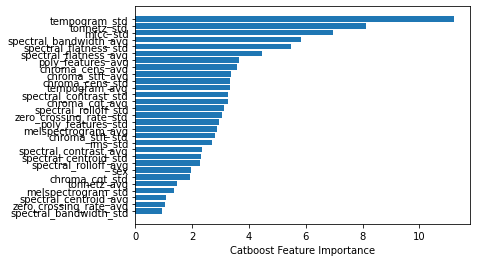

In [12]:
catboost_class(X_train, y_train, X_test, y_test, X, y)

Only 1D features

In [13]:
X = df1d.drop(['tds', 'tds_binary'], axis=1)
y = df1d.tds # Target variable

oversample = SMOTE(k_neighbors=2)
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

val. score: 0.9010184206858299
test score: 0.9249695135412234
best_params: OrderedDict([('depth', 10), ('iterations', 100), ('learning_rate', 0.04)]) 

              precision    recall  f1-score   support

           0       0.92      0.87      0.90        55
           1       0.92      0.90      0.91        60
           2       0.94      1.00      0.97        65

    accuracy                           0.93       180
   macro avg       0.93      0.92      0.92       180
weighted avg       0.93      0.93      0.93       180

0:	learn: 1.0630393	total: 64.5ms	remaining: 6.38s
1:	learn: 1.0304184	total: 125ms	remaining: 6.13s
2:	learn: 0.9954496	total: 187ms	remaining: 6.05s
3:	learn: 0.9620373	total: 246ms	remaining: 5.91s
4:	learn: 0.9321739	total: 307ms	remaining: 5.82s
5:	learn: 0.9045116	total: 368ms	remaining: 5.76s
6:	learn: 0.8749361	total: 431ms	remaining: 5.73s
7:	learn: 0.8498429	total: 497ms	remaining: 5.71s
8:	learn: 0.8237485	total: 558ms	remaining: 5.64s
9:	learn: 0.7988

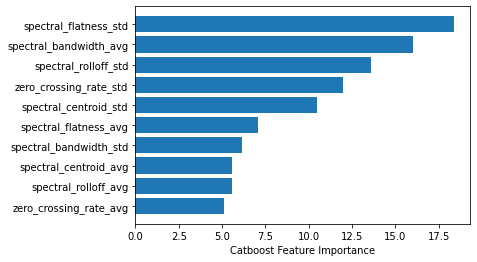

In [14]:
catboost_class(X_train, y_train, X_test, y_test, X, y)

**Binary**

All features

In [15]:
X = df.drop(['tds', 'tds_binary'], axis=1)
y = df.tds_binary # Target variable

oversample = SMOTE(k_neighbors=2)
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

val. score: 0.9457831488392757
test score: 0.9832167832167833
best_params: OrderedDict([('depth', 8), ('iterations', 70), ('learning_rate', 0.04)]) 

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.97      1.00      0.98        32

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60

0:	learn: 0.6540130	total: 18ms	remaining: 1.24s
1:	learn: 0.6140695	total: 31.2ms	remaining: 1.06s
2:	learn: 0.5751779	total: 44.2ms	remaining: 987ms
3:	learn: 0.5384643	total: 57.5ms	remaining: 948ms
4:	learn: 0.5037724	total: 70.8ms	remaining: 920ms
5:	learn: 0.4751805	total: 84.1ms	remaining: 897ms
6:	learn: 0.4511998	total: 97.1ms	remaining: 874ms
7:	learn: 0.4266400	total: 114ms	remaining: 882ms
8:	learn: 0.4022976	total: 127ms	remaining: 859ms
9:	learn: 0.3790764	total: 140ms	remaining: 841ms
10:	learn: 0.35891

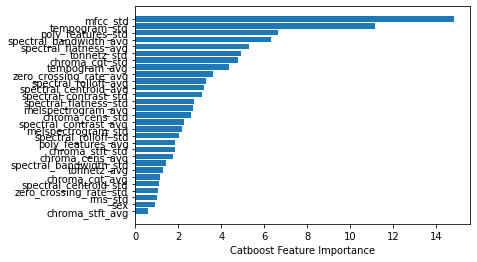

In [16]:
catboost_class(X_train, y_train, X_test, y_test, X, y)

Only 1D features

In [17]:
X = df1d.drop(['tds', 'tds_binary'], axis=1)
y = df1d.tds_binary # Target variable

oversample = SMOTE(k_neighbors=2)
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

val. score: 0.871610896921671
test score: 0.8745732004738345
best_params: OrderedDict([('depth', 8), ('iterations', 30), ('learning_rate', 0.02)]) 

              precision    recall  f1-score   support

           0       0.84      0.89      0.87        55
           1       0.90      0.86      0.88        65

    accuracy                           0.88       120
   macro avg       0.87      0.88      0.87       120
weighted avg       0.88      0.88      0.88       120

0:	learn: 0.6869610	total: 5.21ms	remaining: 151ms
1:	learn: 0.6813699	total: 12.5ms	remaining: 175ms
2:	learn: 0.6750228	total: 17.7ms	remaining: 159ms
3:	learn: 0.6684914	total: 22.9ms	remaining: 149ms
4:	learn: 0.6624464	total: 28.1ms	remaining: 140ms
5:	learn: 0.6564526	total: 33.8ms	remaining: 135ms
6:	learn: 0.6505376	total: 38.6ms	remaining: 127ms
7:	learn: 0.6441576	total: 43.4ms	remaining: 119ms
8:	learn: 0.6391151	total: 48.4ms	remaining: 113ms
9:	learn: 0.6331444	total: 53ms	remaining: 106ms
10:	learn: 0.626

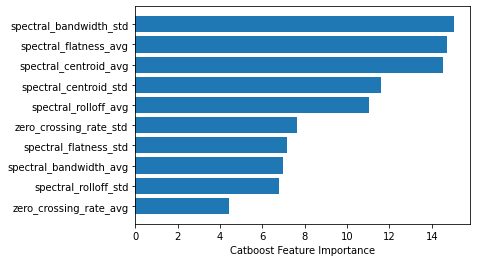

In [18]:
catboost_class(X_train, y_train, X_test, y_test, X, y)